## Problem 1

Consider reaction-diffusion equation with periodic boundary condition

$$u_t(x,t) = u_{xx}(x,t) + \varepsilon u^2,\quad x\in [0,2\pi],$$

$$u(x,0)=e^{-5(x-\pi)^2}, \quad u(0,t)=u(2\pi,t), u_x(0,t)=u_x(2\pi,t).\quad $$

Here $\varepsilon = 1.0$. Use second order finite difference discretization with uniform grid spacing $\Delta x=2\pi/100$.

Obtain the solution $u(x,T)$ at $T=6.0$ using the following methods.

a) Implement a `ForwardEuler` method, using the forward Euler for time discretization and $\Delta t=0.001$.

**(a)**
First we prepare the derivations:

We use the central finite difference to discretize $u_{xx}(x,t)$, with a uniform grid spacing $\Delta x=2\pi/100$, therefore

$$
u_{xx}(x_i,t_n)\approx \frac{u(x_i+\Delta x,t_n)-2u(x_i,t_n)+u(x_i-\Delta x,t_n)}{\Delta x^2}.
$$
This is of order $O(\Delta x^2)$ approximation to $u_{xx}$.
Then, fixing each $x_i$, we obtain:
\begin{equation}
\dot{u}_0 (t) = u_t(0, t) = \frac{1}{\Delta x^2} (u_1 - 2u_0 + u_{-1}) + \epsilon u(0, t_n)^2 
= \frac{1}{\Delta x^2} (u_1 - 2u_0 + u_{-1}) + \epsilon u_0^2 \\
\dot{u}_1 (t) = u_t(\Delta x, t) = \frac{1}{\Delta x^2} (u_2 - 2u_1 + u_0) + \epsilon u(\Delta x, t_n)^2
= \frac{1}{\Delta x^2} (u_2 - 2u_1 + u_0) + \epsilon u_1^2 \\
\dot{u}_2 (t) = u_t(2\Delta x, t) = \frac{1}{\Delta x^2} (u_3 - 2u_2 + u_1) + \epsilon u(2\Delta x, t_n)^2 
= \frac{1}{\Delta x^2} (u_3 - 2u_2 + u_1) + \epsilon u_2^2 \\ 
\vdots \\
\dot{u}_N (t) = u_t(N\Delta x, t) = \frac{1}{\Delta x^2} (u_{N+1} - 2u_N + u_{N-1}) + \epsilon u(N\Delta x, t_n)^2
= \frac{1}{\Delta x^2} (u_{N+1} - 2u_N + u_{N-1}) + \epsilon u_N^2
\end{equation}
Thanks to the periodic boundary condition, we can replace $u_{-1}, u_{N+1}$ by $u_N, u_0$. Compactly, this can be represented by:
\begin{equation}
\mathbf{\dot{u}_t} = \frac{1}{\Delta x^2} \mathbf{\tilde{A}} \mathbf{u} + \epsilon \mathbf{u}^2 
= A \mathbf{u} + \epsilon \mathbf{u}^2 
\end{equation}, where $\mathbf{\tilde{A}}$ is:
$
\begin{pmatrix}
    -2 & 1 & 0 & \dots & 0 & 1 \\
    1 & -2 & 1 & 0 & \dots & 0 \\
      & \ddots & \ddots & \ddots & \vdots & \vdots \\
      & & \ddots & \ddots & \ddots \\
      0 & \dots & 0 & 1 & -2 & 1 \\
      1 & 0 & \dots & 0 & 1 & -2
\end{pmatrix}
$.

In our setup below $A = \frac{1}{\Delta x^2} \tilde{A}$ actually.

Our Forward Euler is simply:
$$
    u_{n+1} = u_n + \Delta t F(u_n)
$$ where $F$ is our above $\dot{u_t} = F(u)$ relation.

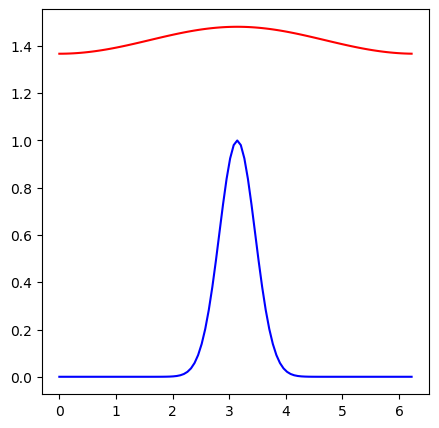

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x129502e10>

In [1]:
using LinearAlgebra
using SparseArrays

#= helper: represents F applied on u, according
to the derivation above (right hand side), and 
it returns a 100 x 1 vector. A is our matrix, 
u is the u_n vector. epsil is epsilon. =#
function F(u, A, epsil)
    out = A * u + epsil * u.^2;
    return out
end
function ForwardEuler(N,T,u0,A,epsil)
    u = zeros(Ns, N);
    dt = T/N
    u[:,1] = u0
    for i in 1:N-1
        u[:,i+1] = u[:,i] + dt * F(u[:,i], A, epsil)
    end
    return u
end

Ls = 2*pi
Ns = 100
hs = Ls / Ns
xs = collect(0:Ns-1)*hs

A = 1.0/hs^2 * spdiagm(-1=>ones(Ns-1),0=>-2.0*ones(Ns),1=>ones(Ns-1))
A[1,Ns] = 1.0 / hs^2
A[Ns,1] = 1.0 / hs^2
u0 = exp.(-5.0*(xs.-pi).^2)

T  = 6.0
dt = 0.001
N  = round(Int64,T/dt)
t  = collect(0:N)*dt
epsil = 1.0

uForwardEuler = ForwardEuler(N,T,u0,A,epsil)

using PyPlot
figure(1,figsize=(5,5))
plot(xs,vec(uForwardEuler[:,1]),"b-")
plot(xs,vec(uForwardEuler[:,N]),"r-")

b) Implement a `CNBroyden` method, using a trapezoidal rule for time discretization and $\Delta t = 0.1$. This is also called the Crank-Nicolson method. Use any type of Broyden's method to solve the nonlinear equation. The starting guess for Broyden's matrix can be chosen as $B_0=\alpha I$, $\alpha=0.05$. Plot the number of iterations of Broyden's method for each step to reach certain stopping criterion (say $10^{-8}$).

Hint: the simplest version of Broyden's method to implement is the rank-1 update version with limited history of size 1.

Following our above implementation, we use the scheme:
$$
    u_{n+1} = u_n + \frac12 \Delta t (F(u_{n+1}) + F(u_n))
$$

The motivation for Broyden method is to approximate $J^{-1}(u_n)$ at each time step and therefore:
$$
u_{n+1} = u_n - B_n \mathbf{F}(u_n)
$$ where $B_n$ is the Broyden matrix at $t_n$, $\mathbf{F}$ is the iteration; not the original righthand side.
let $s_k = u_k - u_{k-1}$, $y_k = \mathbf{F}(u_k) - \mathbf{F}(u_{k-1}) \approx J(u_k)s_k$.
The Broyden's condition is:
$$
    s_k = B_k y_k
$$

Through derivation, we use the update at each step:
$$
    B_k = B_{k-1} - (B_{k-1}y_k - s_k) (y_k^T y_k)^{-1} y_k^T
$$

To derive the correct iterative formula, consider the function $\mathbf{F}(u_{n+1})$ as our iteration (since we need to implicitly solve $u_{n+1}$ at each time step, we do iteration on $u_{n+1}$, assuming $u_n$ is known.

Therefore we have:
$$
    \mathbf{F}(u_{n+1}) = u_{n+1} - T(u_{n+1}) = 0 \\
    \mathbf{F}(u_{n+1}) = u_{n+1} - (\frac12 h f(u_{n+1}) + (\frac12 f(a) + a)) = 0
$$ where $a = u_n$ which is assumed to be known and constant at each time step.

For our iterative scheme, we consider at each timestep $u_n$ is known and fixed, and want to iteratively solve $u_{n+1}$. Then the iteration can be defined as:
$$
    \mathbf{F}(u_{n+1}^{(\mathbf{k})}) = u_{n+1}^{(k)} - (\frac{1}{2}h f(u_{n+1}^{(k)}) + (\frac12 hf(a) + a))
$$ thus giving us the quasi-Newton:
$$
    u_{n+1}^{(k+1)} = u_{n+1}^{(k)} - B_k \mathbf{F(u_{n+1}^{(k)})}
$$

In [ ]:
id = Matrix{Float64}(I, Ns, Ns)
alpha = 0.05
B0 = alpha * I # initial Broyden guess
#= Update Broyden matrix at this step. Returns a new Broyden matrix. =#
function update(Bk, yk, sk)
    return Bk - (Bk*yk - sk) * inv((transpose(yk) * yk)) * transpose(yk)
end
#= One step of original functional iteration. =#
function G(uk, u_last)
    #u_new = uk + 0.5 * dt * (F(uk, A, epsil) + F(uk_prev, A, epsil))
    a = u_last
    u_new = uk - (0.5*dt*F(uk,A,epsil) + 0.5*dt*F(a,A,epsil) + a)
    return u_new
end

#= One step of broyden iteration, returns a vector
u(k+1). =#
function broyden_iter(u, u_last, Bk)
    u_new = u - Bk * G(u, u_last)
    return u_new
end
################# helper functions above

function CNBroyden(N,T,u0,A,epsil,alpha,maxIter)
    u = zeros(Ns, N); Niter = zeros(N)
    u[:,1] = u0;
    dt = T/N
    for i in 1:N-1
        u_prev = u[:,i]; # previous iteration to use for convergence test, start as previous step
        Bk = B0; # initial Bk guess
        u_last = u[:,i]
        u[:,i+1] = u_prev + dt * F(u_prev, A, epsil) # FE, initial guess, to be iteratively updated
        while norm(u[:,i+1] - u_prev) > 10^(-8)
            if Niter[i+1] > maxIter
                Niter[i+1] = maxIter
                break 
            else
                u_prev = u[:,i+1]
                u[:,i+1] = broyden_iter(u_prev, u_last, Bk)
                Niter[i+1] = Niter[i+1] + 1
            end
            end # end while
        Bk = update(Bk, u[:,i+1]-u_prev, G(u[:,i+1], u_last)- G(u_prev, u_last))
        
    end
    return u,Niter
end

Ls = 2*pi
Ns = 100
hs = Ls / Ns
xs = collect(0:Ns-1)*hs

A = 1.0/hs^2 * spdiagm(-1=>ones(Ns-1),0=>-2.0*ones(Ns),1=>ones(Ns-1))
A[1,Ns] = 1.0 / hs^2
A[Ns,1] = 1.0 / hs^2
u0 = exp.(-5.0*(xs.-pi).^2)

T  = 6.0
dt = 0.1
N  = round(Int64,T/dt)
t  = collect(0:N)*dt
epsil = 1.0
alpha = 0.05
maxIter = 200

uCNBroyden,Niter = CNBroyden(N,T,u0,A,epsil,alpha,maxIter)

using PyPlot
figure(1,figsize=(5,5))
plot(xs,vec(uCNBroyden[:,1]),"b-")
plot(xs,vec(uCNBroyden[:,N]),"r-")

figure(2,figsize=(5,5))
plot(t[1:N],Niter,"b-o")

## Problem 2

Use the five-point finite difference formula and solve 

$$-\Delta u(x,y) = 1, \quad u\vert_{\partial \Omega} = 0,$$

on a $L$-shaped domain (see below, blue shaded region)

$$\Omega=((0,1)\times(0,1)) \backslash ([1/2,1]\times[1/2,1]).$$

Use a grid spacing $h=1/(N+1)$ and $N=200$. 

1) Write a function `FDLshape` which returns $X,Y,U$, so that $U_{i,j}$ is the approximate solution for $u(X[i,j],Y[i,j])$. If $(X[i,j],Y[i,j])$ is not in $\Omega$, $U_{i,j}=0$. Plot the solution $U$. You can solve the equation using the backslash directly.

2) Write a function `FDLshapeCG` which does the same job, but uses the conjugate gradient solver to solve the linear system and get the same result. You should write your own CG solver instead of using external packages.

This is how you obtain (something close to) MATLAB's logo!

https://www.mathworks.com/company/newsletters/articles/the-mathworks-logo-is-an-eigenfunction-of-the-wave-equation.html

*(1) Derivation:*
We have the Laplacian 5 point stencil:
$$
    \Delta u(x_i,y_i) \approx \frac{u(x_{i-1},y) + u(x_{i+1},y) + u(x_i,y_{i-1}) + u(x_i,y_{i+1}) - 4 u(x_i,y_i))}{h^2}
$$

For all $u_{i,j}$, this uniquely defines a matrix:
$$
    -\Delta u_{i,j} = 1
$$ for $i, j = 1, 2, ..., 200$ is equivalent to:
$$
    A \mathbf{\cdot} \begin{pmatrix}
            u_{1,1} \\
            u_{2,1} \\
            \vdots \\
            u_{99,1} \\
            u_{100,1} \\
            \vdots \\
            u_{200,1}\\
            \vdots \\
            u_{1,2} \\
            u_{2,2} \\
            \vdots \\
            u_{200,2} \\
            \vdots \\
            \vdots \\
            u_{200,199} \\
            u_{1,200} \\
            \vdots \\
            u_{199,200} \\
            u_{200,200}
        \end{pmatrix} = 1e_{40000}
$$ this is a $40000 \times 1$ vector, where $A$ is a ($40000 \times 40000$)sparse matrix subject to rules:
$$
    \mbox{1. } diag(A) = 4 \\
    \mbox{2. } A[i+1,j] = -1 \mbox{ where $1 \le i,j \le 39999$ except for certain points $200, 400, 600, \dots, 39800$ we have that $A[i+1,j] = 0$} \\
    \mbox{3. symmetric to 2. with $i,j$ swapped.} \\
    \mbox{4. } A[i+200,j] = -1 \mbox{ where $1 \le i,j \le 39800$} \\
    \mbox{5. symmetric to 4. with $i,j$ swapped.}
$$

To lead to a sparse matrix, we define a mapping of sequential labeling to X-Y grid entry of $U$:
$$
    1 \rightarrow u_{1,1} \\
    2 \rightarrow u_{2,1} \\
    \vdots \\
    200 \rightarrow u_{200,1} \\
    201 \rightarrow u_{1,2} \\
    \vdots \\
    \vdots \\
    39801 \rightarrow u_{1,200} \\
    \vdots \\
    40000 \rightarrow u_{200,200}   
$$ namely this is a mapping from sequence number to an $(i,j)-$entry by the rule:
$$
    x \rightarrow (x \mbox{ mod } 200, \mbox{ceiling(}x \mbox{ / } 200 \mbox{)})
$$

We construct the matrix in this way, and directly solve a $40000\times1$ vector using backslash.

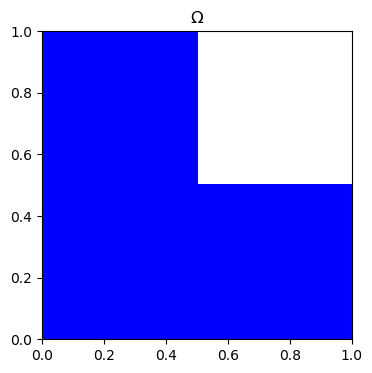

PyObject Text(0.5, 1, '$\\Omega$')

In [144]:
function ndgrid(v1::AbstractVector{T}, v2::AbstractVector{T}) where T
    m, n = length(v1), length(v2)
    v1 = reshape(v1, m, 1)
    v2 = reshape(v2, 1, n)
    (repeat(v1, 1, n), repeat(v2, m, 1))
end

x1d=LinRange(0,1,100)
X,Y=ndgrid(x1d,x1d)
Z=zeros(size(X))
for j = 1 : prod(size(X))
    if(X[j]>=0.5 && Y[j]>=0.5)
        Z[j] = 1.0
    else
        Z[j] = 0.0
    end
end

using PyPlot
figure(1,figsize=(4,4))
contourf(X,Y,Z,[0.00,0.99,1.01],colors=("b","w"))
title(L"\Omega")

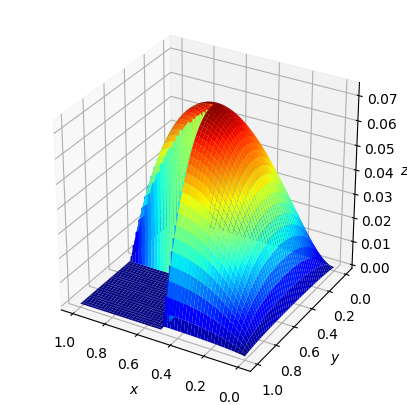

PyObject Text(0.0936277532959891, 0.012543740442400291, '$z$')

In [147]:
using LinearAlgebra
using SparseArrays 
# helper matrix A defined above
len = 40000
big = spdiagm(-1=>-1*ones(len-1),0=>4.0*ones(len),1=> -1 * ones(len-1), -200=> -1*ones(len-200),200=> -1*ones(len-200))
for j in 200 * collect(1:199)
    big[j+1,j]=0
    big[j,j+1]=0
end
#big[20000:40000,20000:40000] .= 0 # L-shape
#######
function FDLShape(L,N)
    dx = L/(N+1)
    A = big
    b_vector = (dx^2) * ones(N*N)
    u_vector = A\b_vector
    U = collect(reshape(u_vector,(200,200)))
    U[100:200,100:200] .= 0
    lin_length = LinRange(0,1,200)
    X,Y = ndgrid(lin_length,lin_length)
    return X,Y,U
end

X,Y,U = FDLShape(1.0,200)
h=figure(1,figsize=(5,5))
ax = h.add_subplot(111,projection="3d")
surf(X,Y,U,edgecolors="none",cmap=ColorMap("jet"),shade="true")
ax.view_init(elev=30.0,azim=120.0)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")

***Note:***
The projection='3d' in add_subplot may not work too well.
If it errors when the code is run for the first time, take out the "projection='3d'", run code again (will error for certain), and then put back "projection='3d'", this time the plot will be displayed.

*(b) Derivation*

The CG algorithm:
$$
\mbox{Make an initial guess $u_0$} \\
\mbox{compute residual: } r_0 = b - Au_0 \\ 
\mbox{initial direction, same as SD: } p_0 = r_0 \\
\mbox{for } \mbox{iter k } = 1, 2, \dots \\
w_{k-1} = Ap_{k-1} \\
\alpha_{k-1} = \frac{r_{k-1}^T r_{k-1}}{p_{k-1}^T w_{k-1}} \\
u_k = u_{k-1} + \alpha_{k-1} p_{k-1} \\
r_k = r_{k-1}-\alpha_{k-1}w_{k-1} \\
\mbox{if $\Vert r_{k}\Vert$ tolerance is met: } break \\
\beta_{k-1} = \frac{r_k^T r_k}{r_{k-1}^T r_{k-1}} \\
p_k = r_k + \beta_{k-1}p_{k-1}
$$

In [150]:
# Conjugate gradient solver

function CG(A,b,x0,tol=1e-5,maxit=1000)
    r = b - A * x0;
    x = x0
    p = r;
    rsold = transpose(r) * r;
    if norm(rsold) < tol
        return x
    end
    for i in collect(1:length(b))
        Ap = A * p;
        alpha = rsold / (transpose(p) * Ap);
        x = x + alpha * p;
        r = r - alpha * Ap;
        rsnew = transpose(r) * r;
        if sqrt(rsnew) < tol
              break;
        end
        p = r + (rsnew / rsold) * p;
        rsold = rsnew;
    end
    return x
end

CG (generic function with 3 methods)

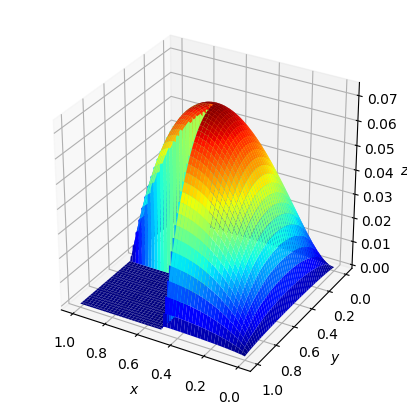

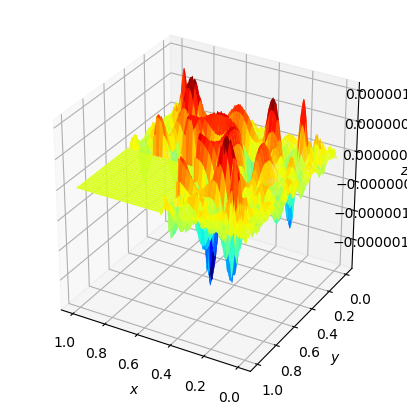

PyObject Text(0.0936277532959891, 0.012543740442400302, '$z$')

In [151]:
function FDLShapeCG(L,N)
    dx = L/(N+1)
    A = big
    b_vector = (dx^2) * ones(N*N)
    u_vector = CG(A,b_vector,ones(N*N))
    U = collect(reshape(u_vector,(200,200)))
    U[100:200,100:200] .= 0
    lin_length = LinRange(0,1,200)
    X,Y = ndgrid(lin_length,lin_length)
    return X,Y,U
end

X,Y,UCG = FDLShapeCG(1.0,200)
h=figure(1,figsize=(5,5))
ax = h.add_subplot(111, projection="3d")
surf(X,Y,UCG,edgecolors="none",cmap=ColorMap("jet"),shade="true")
ax.view_init(elev=30.0,azim=120.0)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")


h=figure(2,figsize=(5,5))
ax = h.add_subplot(111, projection="3d")
surf(X,Y,U-UCG,edgecolors="none",cmap=ColorMap("jet"),shade="true")
ax.view_init(elev=30.0,azim=120.0)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")


## Problem 3

Consider a matrix $A\in \mathbb{R}^{N\times N}$. $A$ is diagonalizable with only two distinct eigenvalues $\pm 1$. Prove that for any right hand side $b$ and initial guess $x_0$, GMRES solves the equation $Ax=b$ with at most 2 iterations.

**Proof:**

Let $u_{\pm1}$ the eigenvectors corresponding to the eigenvalue $\pm 1$. 

For initial guess $x_0$, residual is $r_0=b-Ax_0$. Normalize $v_0=\frac{r_0}{\Vert{r_0}\Vert}$, then $v_0$ can be written as a linear combination of the eigenspace:
$$
v_0=\lambda_{1} u_{+1} + \lambda_{-1} u_{-1}.
$$ where $\lambda$ is some scaling constant.

Since it is decomposed with respect to the eigenspace, we have,
$$
Av_0=\lambda_{+1}u_{+1} - \lambda_{-1}u_{-1}.
$$ because $Au_{+1} = u_{+1}$, $Au_{-1} = -u_{-1}$.

If either $\lambda = 0$, this means $Au_{+1}$ or $Au_{-1}$ is linearly dependent with $u_{+1}$ or $u_{-1}$. GMRES converges within 1 step.

In another case we must have:
$$
A\cdot (Av_0)=\lambda_{+1} u_{+1} +  \lambda_{-1}u_{-1} = v_0.
$$
Then exists an invertible $2\times 2$ matrix $H$, and $v_1$ orthogonal to $v_0$ such that
$$
A[v_0, v_1] = [v_0, v_1] H.
$$
GMRES converges in 2 steps.

## Problem 4

The nonlinear Schrodinger equation in 1D

$$\imath \partial_t u(x,t) = -\partial_{xx} u(x,t)+\beta \vert u(x,t)\vert^2 u(x,t), \quad x\in \mathbb{R}$$

has an exact solution  

$$\psi_{exact}(x,t) = \frac{2a}{\beta} \text{sech}\left[\sqrt{a}(x-x_0-ct)\right] \exp\left[\imath \frac{c}{2}(x-x_0)-\imath\left(\frac{c^2}{4}-a\right)t\right].$$

Here we choose the parameter

$\beta=-8.0,a=\beta^2/16,c=0.5,x_0=-3.0$.


Solve this problem on a finite sized domain $[-L/2,L/2]$ with $L=20$ and periodic boundary condition. Use the central finite difference scheme for spatial discretization. 

(1) Write a routine `rk4` to compute the solution at $T_f=1.0$ using the RK4 method. You need to choose the grid size (spatial and temporal) so that the maximum absolute error of the solution (by comparing to the exact solution) is less than $10^{-3}$.

*Derivations:*

As usual, we have the RK4 method:
$$
k_1 = f(u_n, t_n) \\
k_2 = f(u_n + \frac12 h k_1, t_n + \frac12 h) \\
k_3 = f(u_n + \frac12 h k_2, t_n + \frac12 h) \\
k_4 = f(u_n + hk_3, t_n + h) \\
u_{n+1} = u_n + h(\frac16 k_1 + \frac13 k_2 + \frac13 k_3 + \frac16 k_4)
$$

Using the central difference discretization, we have:
$$
    \partial_{xx} u(x_i,t_n)\approx \frac{u(x_i+\Delta x,t_n)-2u(x_i,t_n)+u(x_i-\Delta x,t_n)}{\Delta x^2}.
$$

Rearrganing the original equation, we have:
$$
i \partial_t u(x,t) = -\partial_{xx} u(x,t)+\beta \vert u(x,t)\vert^2 u(x,t) 
\\ 
\partial_t u = i \partial_{xx} u - i \beta \vert u \vert^2 u
$$

Using the discretization: we have
$$
    \partial_t \mathbf{u} = \frac{i}{(\Delta x)^2} A \mathbf{u} - i \beta (\mathbf{\vert u\vert^2}u) \\
    = i \cdot \mathcal{Lap} (\mathbf{u}) - i \beta (\mathbf{\vert u\vert^2}u)
$$

where 
$$ A =
\begin{pmatrix}
    -2 & 1 & 0 & \dots & 0 & 1 \\
    1 & -2 & 1 & 0 & \dots & 0 \\
      & \ddots & \ddots & \ddots & \vdots & \vdots \\
      & & \ddots & \ddots & \ddots \\
      0 & \dots & 0 & 1 & -2 & 1 \\
      1 & 0 & \dots & 0 & 1 & -2
\end{pmatrix}
$$ and $\mathbf{u}$ is an $N \times 1$ vector representing the spatially discretized $u$.

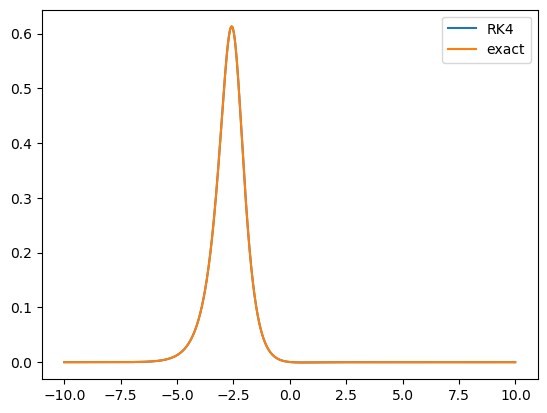

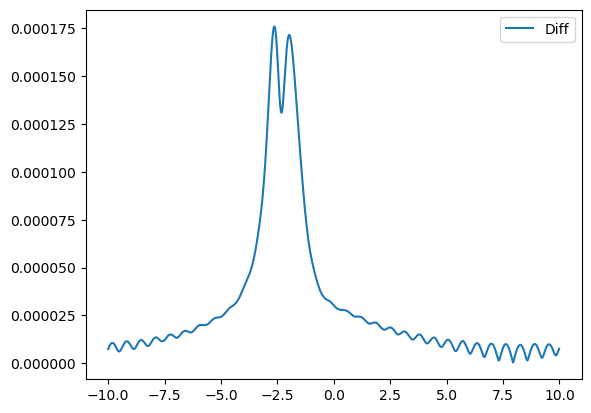

PyObject <matplotlib.legend.Legend object at 0x1359fdb00>

In [152]:
using LinearAlgebra
using SparseArrays
Ns = 1600
Ls = 20
hs = Ls/Ns
xs = -Ls/2 .+ collect(0:Ns-1)*hs
Lap = 1.0/hs^2 * spdiagm(-1=>-ones(Ns-1),0=>2.0*ones(Ns),1=>-ones(Ns-1))
Lap[1,Ns] = -1/hs^2
Lap[Ns,1] = -1/hs^2

β = -8.0
a = β^2/16.0
c = 0.5
x0 = -3.0
function F(u,Lap,β)
    #=helper method: represents ut = f(u) the right hand side. =#
    return im * (-Lap * u .- β * ((abs.(u)).^2) .* u)
end
#=========#
function rk4(NT,T,u0,Lap,β)
    U = zeros(Complex{Float64}, Ns, NT)
    dt=T/NT;
    U[:,1]=u0
    for i in 1:NT-1
        u_i = U[:,i]
        k1 = F(u_i,Lap,β)
        k2 = F(u_i + 0.5 * dt * k1,Lap,β)
        k3 = F(u_i + 0.5 * dt * k2,Lap,β)
        k4 = F(u_i + dt * k3,Lap,β)
        U[:,i+1] = u_i + dt * ((1/6) * k1 + (1/3) * k2 + (1/3) * k3 + (1/6) * k4)
    end
    u = U[:,end]
    return u
end

psiexact_func(x,t) = 2.0*a/β * sech(sqrt(a)*(x-x0-c*t)) * exp(im*(c/2.0*(x-x0)-(c^2/4.0-a)*t))

psi0 = psiexact_func.(xs,0.0)

NT = 10000
Tf = 1.0
psi = rk4(NT,Tf,psi0,Lap,β)
psiexact = psiexact_func.(xs,Tf)

using PyPlot
figure(1)
plot(xs,real(psi),label="RK4")
plot(xs,real(psiexact),label="exact")
legend()

figure(2)
plot(xs,abs.(psi-psiexact),label="Diff")
legend()

(2) Write a routine `IMEX` to do the same thing with the IMEX method, where the implicit scheme is chosen to be the trapezoidal rule, and the explicit scheme is AB2.  If there is a linear system to be solved, use GMRES to solve the linear system.

You should write your own GMRES solver instead of using external packages. The solution of reduced linear system should use the efficient implementation based on Given rotation.

see, e.g.

https://www.math.ucla.edu/~jteran/270c.1.11s/notes_wk2.pdf

or

Y. Saad, Iterative methods for sparse linear systems, SIAM, 2003; Chap 6.5

*(2) Derivation:*

The IMEX method is based on
$$
    \frac{d}{dt} u = Lu + N(u,t)
$$ and performing implicit finite differencing on the linear part and explicit method on $N$.

In our formulation:
$$
\frac{d}{dt} u = i \cdot \mathcal{Lap} \cdot u - i \beta (\vert u\vert^2u) \\
= F(u) + G(u)
$$ where $F$ is the stiff linear part, and $G$ is the nonlinear part. We apply trapezoidal on $F$ and AB2 on $G$.


Leading to the rule:
$$
    u_{n+1} = u_n + \frac{\Delta t}{2} (F(u_{n+1}) + F(u_n)) + \frac{\Delta t}{2} (3 G(u_n) - G(u_{n-1}))
$$

where 
$$
    F(u) = i \cdot \mathcal{Lap} \cdot u
$$ and
$$
    G(u) = - i \beta (\vert u \vert^2 u)
$$

expanding our expression gives:
$$
    u_{n+1} = u_n + \frac12 h (iQu_{n+1} + iQu_n) + \frac12 h (-3i\beta \vert u_n \vert^2 u_n + i\beta \vert u_{n-1} \vert^2 u_{n-1}))
$$ where $Q = \mathcal{Lap}$

Further simplifying and rearranging gives our scheme:
$$
    (I - \frac12 ihQ)u_{n+1} = (I + \frac12 ihQ)u_n - \frac32 ih\beta \vert u_n\vert^2u_n + \frac12 ih\beta \vert u_{n-1}\vert^2 u_{n-1}
$$ therefore to obtain $u_{n+1}$, we need to solve the linear system of the form $Au_{n+1} = b$ where $b = N(u_n, u_{n-1})$.

***Derivation of the GMRES with Givens Rotation***

At each step, we would like to perform:
$$
    \min_{y} \Vert b-Ax_k \Vert_2 
$$ and
$$
    x_k = x_0 + Q_ky_k
$$ where $x_0$ is our initial guess, $Q_k$ is the matrix with orthogonal columns arised from the $k$-th step, and $y_k$ is choosen to minimize the residual.

Then:
$$
    b-Ax = b-A(x_0 + Q_ky_k) \\
    = (b-Ax_0) - AQ_ky_k \\
    = r_0Q_ke_1 - \tilde{H_k}y_k \\
    = Q_{k+1}(r_0\tilde{e_1}-\tilde{H_k}y_k)
$$ where $\tilde{e} = \begin{pmatrix} e \\ 0 \end{pmatrix}$ for dimension matching, $H$ is upper-hessenberg and $\tilde{H} = \begin{pmatrix}  && H && && \\ 0 && \dots && 0 && h_{k+1,k} \end{pmatrix}$.

Therefore at $k$-th iteration we are solving the problem:
$$
    \min_{y}\Vert \beta \tilde{e_1} - \tilde{H_k}y_k \Vert_2
$$ where $\beta = \begin{pmatrix} \Vert r_0 \Vert_2 \\ 0 \end{pmatrix}$ that satisfies: $ r_0 = Q_{k+1}\beta$.

For stability reasons, using Arnodi to obtain the new orthonormal basis (columns of $Q_k$), the procedure:
$$
    q_1 = \frac{r_0}{\Vert r_0 \Vert} \\
    \mbox{for } k = 1, 2, \dots \\
    v = Aq_k \\
    \mbox{for } i = 1,2,\dots,k \\
    h_{ik} = q_i^T v \\
    v = v-h_{ik}q_i \\
    \\
    h_{k+1,k} = \Vert v\Vert_2 \\
    q_{k+1} = \frac{v}{h_{k+1},k} \\
$$

For the $QR$ factorization solving the least-squares problem, we use Givens rotation: the $G(i,j;\theta)$ matrix is defined as taking the identity matrix and replacing:
$$
    \begin{pmatrix}
        I_{i,i} && I_{i,j} \\
        I_{j,i} && I_{j,j}
    \end{pmatrix}
$$ by
$$
    \begin{pmatrix}
        \cos{\theta} && \sin{\theta} \\
        -\sin{\theta} && \cos{\theta}
    \end{pmatrix}
$$ where $\theta$ is found to be $\arctan{\frac{a}{b}}$, preserving the norm and orthogonality. Such that:
$$
    \begin{pmatrix}
        \cos{\theta} && \sin{\theta} \\
        -\sin{\theta} && \cos{\theta}
    \end{pmatrix} \cdot \begin{pmatrix} a \\ b \end{pmatrix}
    = \begin{pmatrix} \star \\ 0 \end{pmatrix}
$$

In [153]:
using LinearAlgebra
# GMRES method with Givens rotation.
function rotation_matrix(a, b)
    if a==0
        cs=0; sn=1;
    else
        t=sqrt(a^2+b^2);
        cs=abs(a)/t;
        sn=cs*b/a;
    end
    return cs,sn
end


function givens_rotate(h,cs,sn,k)
    #= givens rotation applying on the ith col, and update for next rotation. =#
    for i in collect(1:k-1)
        val=cs[i]*h[i] + sn[i]*h[i+1];
        h[i+1] = -sn[i]*h[i] + cs[i]*h[i+1];
        h[i]=val;
    end
    cs_k,sn_k=rotation_matrix(h[k],h[k+1]);
    h[k]=cs_k*h[k] + sn_k*h[k+1];
    h[k+1] = 0.0;
    return h,cs_k,sn_k
end


function arnoldi(A,Q,k)
    #= orthogonalization using Arnoldi procedure. =# 
    q=A*Q[:,k]
    h = zeros(Complex{Float64},k+1)
    for i in collect(1:k)
        h[i]=transpose(q)*Q[:,i]
        q=q-h[i]*Q[:,i]
    end
    h[k+1]=norm(q)
    q=q/h[k+1]
    return h,q
end


#===============##Helper methods above


function gmresGivens(A,b,x0,tol=1e-5,maxiter=1000)
    n=length(A[:,1]); m = maxiter;
    r=b-A*x0
    b_norm = norm(b)
    err=norm(r)/b_norm
    sn = zeros(Complex{Float64},m,1)
    cs = zeros(Complex{Float64},m,1)
    e1 = zeros(n,1)
    e1[1] = 1
    e = [err]
    r_norm = norm(r)
    Q = r/r_norm # Q is n by k (k is dim(Krylov))
    put_in_beta = r_norm*e1
    beta = zeros(Complex{Float64},m)
    beta[1:length(e1)] =  put_in_beta
    H = zeros(Complex{Float64},m+1,m) # H is n+1 by n in the end
    for k in collect(1:m)
        h_vector_k, Q_k_plus_one = arnoldi(A,Q,k)
        H[1:k+1,k] = h_vector_k
        Q = [Q Q_k_plus_one]
        
        rotated_h,cs_k,sn_k = givens_rotate(h_vector_k,cs,sn,k)
        H[1:k+1,k] = rotated_h; cs[k] = cs_k; sn[k] = sn_k;
        if k+1 > length(beta)
            append!(beta,zeros(k+1-length(beta),1));
            beta[k+1] = -sn[k] * beta[k];
            beta[k] = cs[k] * beta[k]
        else
            beta[k+1] = -sn[k] * beta[k];
            beta[k] = cs[k] * beta[k]
        end
        err = abs(beta[k+1]) / b_norm
        e = [e;error]
        if err <= tol
            break;
        end
    end
    y = H[1:k,1:k] \ beta[1:k];
    x = x0 + Q[:,1:k]*y; 
    return x
end

gmresGivens (generic function with 3 methods)

For simplicity, we test the GMRES with Givens rotation on the test problem of solving:
$$
    \mathbf{Ax} = \mathbf{b} \\
    \begin{pmatrix}
        4 && 1 \\
        1 && 3
    \end{pmatrix} \cdot \mathbf{x} =
    \begin{pmatrix}
        1 \\ 2
    \end{pmatrix}
$$ which has the exact solution:
$$
    \mathbf{x_{exact}} = \begin{pmatrix} \frac{1}{11} \\ \frac{7}{11} \end{pmatrix} \approx 
    \begin{pmatrix}
        0.0909 \\
        0.6364
    \end{pmatrix}
$$

We solve this system using GMRES with initial guess $\mathbf{x_0} = \begin{pmatrix} 2 \\ 1 \end{pmatrix}$.

In [154]:
test_A = [4.0 1.0; 1.0 3.0]
test_b = [1.0; 2.0]
x_exact = test_A\test_b;
x_CG = CG(test_A,test_b,[2.0;1.0])
x_gmres = gmresGivens(test_A,test_b,[2.0;1.0])
println("We obtain these results: ")
println("===============")
println("exact solution is: ", x_exact)
println("===============")
println("x solved using CG: ", x_CG)
println("===============")
println("x solved using GMRES: ", x_gmres)
println("===============")

We obtain these results: 
exact solution is: [0.09090909090909091, 0.6363636363636364]
x solved using CG: [0.09090909090909094, 0.6363636363636365]
x solved using GMRES: Complex{Float64}[0.0909090909090915 + 0.0im, 0.6363636363636365 + 0.0im]


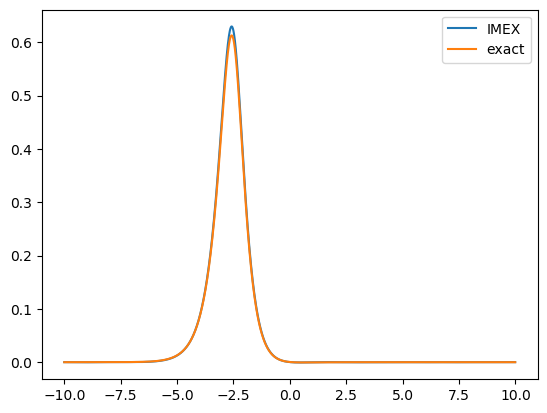

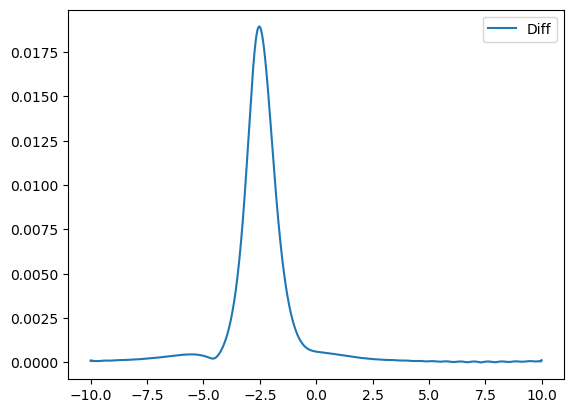

PyObject <matplotlib.legend.Legend object at 0x134e7a550>

In [155]:
# now we code the IMEX method
using LinearAlgebra
using SparseArrays
Ns = 1600
Ls = 20
hs = Ls/Ns
xs = -Ls/2 .+ collect(0:Ns-1)*hs
Lap = 1.0/hs^2 * spdiagm(-1=>-ones(Ns-1),0=>2.0*ones(Ns),1=>-ones(Ns-1))
Lap[1,Ns] = -1/hs^2
Lap[Ns,1] = -1/hs^2
β = -8.0
a = β^2/16.0
c = 0.5
x0 = -3.0

iden = Matrix{Complex{Float64}}(I,Ns,Ns);
############
function righthand_side(v1,v2,dt)
    #= used to compute the right hand side, so that we can solve the form Au(n+1)=b. =#
    vector_b = (iden+0.5*im*dt*-Lap)*v1 - 1.5*im*dt*β*((abs.(v1)).^2) .* v1 + 0.5*im*dt*β*((abs.(v2)).^2) .* v2
    return vector_b
end
############ helper above
function IMEX(NT,T,u0,Lap,β,tol,maxit)
    # use forward euler to do u1
    
    U = zeros(Complex{Float64}, Ns, NT)
    dt=T/NT;
    U[:,1]=u0
    u1 = u0 + dt * F(u0,Lap,β)
    U[:,2]=u1
    for i in 2:NT-1
        u_i = U[:,i]; u_i_minus_1 = U[:,i-1];
        # given ui and ui-1, compute the right hand side
        right = righthand_side(u_i,u_i_minus_1,dt)
        # change to gmres
        BigA = iden - 0.5*im*dt*-Lap
        u_plus = BigA\right
        #u_plus = gmresGivens(BigA,right,u0,tol,maxit)
        U[:,i+1] = u_plus
    end
    u = U[:,end]
    ####
    return u
end

NT = 100

Tf = 1.0

psiexact_func(x,t) = 2.0*a/β * sech(sqrt(a)*(x-x0-c*t)) * exp(im*(c/2.0*(x-x0)-(c^2/4.0-a)*t))
psi = IMEX(NT,Tf,psi0,Lap,β,1e-6,100)
psiexact = psiexact_func.(xs,Tf)

using PyPlot
figure(1)
plot(xs,real(psi),label="IMEX")
plot(xs,real(psiexact),label="exact")
legend()

figure(2)
plot(xs,abs.(psi-psiexact),label="Diff")
legend()

## Problem 5

Here is a way to solve linear systems of equations $Ax = b$ using a quantum computer. $A$ is a $d\times d$ positive definite matrix and $b$ is a $d$-dimensional vector. In quantum computing, one way to approximate the solution $x$ is by propagating the following ODE

$$ i \frac{1}{S} \frac{d}{dt} u(t) = H(t)u(t), \quad u(t) \in \mathbb{C}^d, \quad 0 \leq t \leq 1$$

given the initial condition $u(0) = b/\|b\|_2$. Here $H(t) = (1-t)Q_b + tAQ_bA$ where $Q_b = I - bb^{\top}$ is the projector onto the subspace $\{b\}^{\perp}$, and $S$ is a prefixed positive constant. It can be shown that when $S \rightarrow +\infty$, the exact solution $u(1)$ will, in some sense, approximate $x_n = A^{-1}b/\|A^{-1}b\|_2$, the normalized solution of the linear system. 

Consider 

$$A = \frac{1}{6}\left(\begin{array}{ccc}
  4 & 1 & 1\\
  1 & 3 & 1\\
  1 & 1 & 2\\
\end{array}\right)$$

and 

$$b = \frac{1}{\sqrt{3}}\left(\begin{array}{c}
  1 \\
  1\\
  1\\
\end{array}\right).$$

a) Write a function using Gauss–Legendre method of order four (i.e. 2-step Gauss-Legendre) for time discretization. Solve the ODE for $S = 10^4$ with time step sizes $h = 10^{-k}, k = 1,2,3,4,5$, and compute $\|u(1)u^*(1) - x_nx^*_n\|_2$, where $u^*$ is the conjugate transpose of $u$.  

b) Repeat part a) using RK4 method. Compare the results with part a) and explain the difference.  

c) Solve the ODE again for $S = 1000,2000,5000,10000$, respectively, using Gauss–Legendre method of order four with sufficiently small time step size. Plot $\|u(1)u^*(1) - x_nx^*_n\|_2$ v.s. the choices of $S$ in a loglog plot and estimate the slope of the loglog plot. How does $\|u(1)u^*(1) - x_nx^*_n\|_2$ depend on $S$? 


**Solutions**

(a) *Derivation*
We have the original ODE:
$$ i \frac{1}{S} \frac{d}{dt} u(t) = H(t)u(t), \quad u(t) \in \mathbb{C}^d, \quad 0 \leq t \leq 1$$

Namely:
$$
    \frac{d}{dt} u(t) = -iS \cdot H(t)u(t)
$$

and 
$$
    H(t) = (1-t)Q_b + tAQ_bA
$$

We have the GL2 method, note that there is an explicit dependence on $t$.
For general RK methods:
$$
    k_i = f(u_n + h\sum_{j=1}^s a_{ij}k_j, t_n + c_ih)
$$

We have the scheme:
\begin{equation}
    k_1 = f(u_n + h(\frac{1}{4}k_1 + (\frac{1}{4} - \frac{\sqrt{3}}{6}) k_2), t_n + (\frac12 - \frac{\sqrt{3}}{6})h) \\
    k_2 = f(u_n + h((\frac{1}{4} + \frac{\sqrt{3}}{6})k_1 + \frac{1}{4}k_2), t_n + (\frac12 + \frac{\sqrt{3}}{6})h) \\
    u_{n+1} = u_n + h(\frac{1}{2}k_1 + \frac{1}{2}k_2)
\end{equation}

propogating through $t = [0,1]$. We use time discretization: $h = 0.1, 0.01, 0.001, 0.0001, 0.00001$.

In [156]:
# (a)
# fixed variables
using LinearAlgebra 

A = [4 1 1;1 3 1;1 1 2]/6
b = [1;1;1]/sqrt(3)
S = 10^4

x_exact = A\b
x_exact = x_exact/norm(x_exact);

# useful matrix Qb=I-bb^T
I3 = Matrix{Complex{Float64}}(I, 3, 3)
Qb = I3 - b * transpose(b)
# useful matrix: AQbA: in H(t)
AQbA = A * Qb * A
# complex i
i = im;
# tolerance for iteration
eps = 10^(-8);

In our implicit formulation, we can see at each time step:
$$
k_1 = f(u_n + h(\frac{1}{4}k_1 + (\frac{1}{4} - \frac{\sqrt{3}}{6}) k_2), t_n + (\frac12 - \frac{\sqrt{3}}{6})h) \\
k_2 = f(u_n + h((\frac{1}{4} + \frac{\sqrt{3}}{6})k_1 + \frac{1}{4}k_2), t_n + (\frac12 + \frac{\sqrt{3}}{6})h)
$$
since:
$$
\dot{u} = -iSH(t)u(t) = f(u,t)
$$ we have, after substituting $f$.


Avoding using iterations, we can solve the system directly since it is linear in $t$.
$$
\begin{pmatrix}
    k1 \\
    k2
\end{pmatrix}
=
\begin{pmatrix}
    -iSH(t_n + c_1h) \cdot (u_n + h(a_{11}k_1 + a_{12}k_2)) \\
    -iSH(t_n + c_2h) \cdot (u_n + h(a_{21}k_1 + a_{22}k_2))
\end{pmatrix}
=
-iS
\begin{pmatrix}
    H(t_n + c_1h) && 0 \\
    0 && H(t_n + c_2h)
\end{pmatrix} \cdot
\big[
\begin{pmatrix}
    u_n \\
    u_n
\end{pmatrix}
+ h 
\begin{pmatrix}
    a_{11}I_3 && a_{12}I_3 \\
    a_{21}I_3 && a_{22}I_3
\end{pmatrix} \cdot
\begin{pmatrix}
    k_1 \\
    k_2
\end{pmatrix}
\big]
$$

By a simple rearrangement:
$$
\Big[
    I_6 + iSh \begin{pmatrix}
                  a_{11}I_3 && a_{12}I_3 \\
                  a_{21}I_3 && a_{22}I_3
              \end{pmatrix}
\Big] \cdot
\begin{pmatrix}
    k_1 \\
    k_2
\end{pmatrix}
= -iS \begin{pmatrix}
          H_1 && 0 \\
          0 && H_2
      \end{pmatrix} \cdot \begin{pmatrix}
                              u_n \\
                              u_n
                          \end{pmatrix}
$$

where $H_1, H_2$ are $H(t_n + c_1), H(t_n+c_2)$,
then we simply apply inverse on the left hand side:
$$
    \begin{pmatrix}
        k_1 \\
        k_2
    \end{pmatrix} =
    -iS \Big[
            I_6 + iSh \begin{pmatrix}
                          a_{11} I_3 && a_{12} I_3 \\
                          a_{21} I_3 && a_{22} I_3
                      \end{pmatrix}
        \Big]^{-1} \cdot
        \begin{pmatrix}
            H_1 && 0 \\
            0 && H_2
        \end{pmatrix} \cdot
        \begin{pmatrix}
            u_n \\
            u_n
        \end{pmatrix}
$$
everything is in terms of $6 \times 6$ matrices.

In [160]:
# the GL2 procedure

##########
# useful variables
I6 = Matrix{Complex{Float64}}(I, 6, 6)
a11 = 1/4; a12 = ((1/4) - (sqrt(3)/6)); a21 = ((1/4) + (sqrt(3)/6)); a22 = a11
    c1 = a11+a12; c2 = a21+a22;

Const = zeros(Complex{Float64}, 6, 6)
Const[1:3,1:3] = a11 * I3
Const[1:3,4:6] = a12 * I3
Const[4:6,1:3] = a21 * I3
Const[4:6,4:6] = a22 * I3

Zero6 = zeros(Complex{Float64}, 6, 6) # may be useful to reallocate
##########
function H(t)
     #= helper: compute H for this t. =#
    return (1-t)*Qb + t*AQbA
end

function righthand(un,tn)
   #=helper, computes result of evaluating the right hand side 
    at this u and this t. =#
    return (-i) * S * H(tn) * un
end
function gl2(h,T,u0,S)
    N = round(Int64,T/h)
    t = collect(0:N) * h
    u = zeros(Complex{Float64}, 3, N)
    u[:,1] = u0
    for i in 1:N-1
        un = u[:,i]; tn = t[i];
        # FIXME
        H_Matrix = zeros(Complex{Float64}, 6, 6)
        H1 = H(tn + c1*h); H2 = H(tn + c2*h);
        H_Matrix[1:3,1:3] = H1; H_Matrix[4:6,4:6] = H2;
        une = [un;un]
        righthandside_b = -im * S * H_Matrix * une
        lefthandside_A = I6 + (im*S*h)*Const
        k = lefthandside_A\righthandside_b
        #k = (-im) * S * inv(I6 + (im * S * h) * Const) * H_Matrix * une
        #######
        k1 = k[1:3]; k2 = k[4:6];
        u[:,i+1] = un + h * ( (1/2) * k1 + (1/2) * k2 )
    end
    return u
end

gl2 (generic function with 1 method)

In [161]:
# computations
# stiff?
T=1.0
all_step_sizes = [0.1;0.01;0.001;0.0001;0.00001]
function compute_error(u, x)
    #=helper that computes ||u(1)u*(1) - xn xn*||=#
    return norm(u * adjoint(u) - x * adjoint(x))
end

for h in all_step_sizes
    u1 = gl2(h,T,b,S)
    println("========")
    println("Using step size h = ", h)
    println("Solution at t = 1 is: ", u1[:,end])
    println("And the error from the exact solution is: ", compute_error(u1[:,end], x_exact))
    println("========")
end

Using step size h = 0.1
Solution at t = 1 is: Complex{Float64}[0.5212746799820684 + 0.0010791306922088026im, 0.5808049764489452 + 0.00028226028707575433im, 0.6029962832504451 - 0.0001246734353837209im]
And the error from the exact solution is: 0.5222142387715112
Using step size h = 0.01
Solution at t = 1 is: Complex{Float64}[0.44844475239025594 + 0.09157599578745246im, 0.5856082906351056 + 0.04998454702371863im, 0.6443119231876462 + 0.005922975433504736im]
And the error from the exact solution is: 0.44793299956858196
Using step size h = 0.001
Solution at t = 1 is: Complex{Float64}[0.004724115705721358 - 0.0005590996386861184im, 0.007231163969112561 - 0.0007665909778483139im, 0.0129901367783921 - 0.0023697235595447667im]
And the error from the exact solution is: 0.9997508156608403
Using step size h = 0.0001
Solution at t = 1 is: Complex{Float64}[8.670779263104536e-15 + 2.8347938442225594e-14im, 1.317373948695726e-14 + 4.256834829491539e-14im, 2.4733385002377988e-14 + 8.468220573839444e-

*(b) Derivation*

As usual, we have the RK4 method:
$$
k_1 = f(u_n, t_n) \\
k_2 = f(u_n + \frac12 h k_1, t_n + \frac12 h) \\
k_3 = f(u_n + \frac12 h k_2, t_n + \frac12 h) \\
k_4 = f(u_n + hk_3, t_n + h) \\
u_{n+1} = u_n + h(\frac16 k_1 + \frac13 k_2 + \frac13 k_3 + \frac16 k_4)
$$

In [168]:
function rk4_solver(h,T,u0)
    N = round(Int64,T/h)
    t = collect(0:N) * h
    u = zeros(Complex{Float64}, 3, N)
    u[:,1] = u0
    for i in 1:N-1
        un = u[:,i]; tn = t[i];
        k1 = righthand(un,tn)
        k2 = righthand(un+0.5*h*k1,tn+0.5*h)
        k3 = righthand(un+0.5*h*k2,tn+0.5*h)
        k4 = righthand(un+h*k3,tn+h)
        u[:,i+1] = un + h * ((1/6) * k1 + (1/3) * k2 + (1/3) * k3 + (1/6) * k4)
    end
    return u
end

# computations
# stiff?
T=1.0
all_step_sizes = [0.1;0.01;0.001;0.0001;0.00001]
function compute_error(u, x)
    #=helper that computes ||u(1)u*(1) - xn xn*||=#
    return norm(u * adjoint(u) - x * adjoint(x))
end

for h in all_step_sizes
    u1 = rk4_solver(h,T,b)
    println("========")
    println("Using step size h = ", h)
    println("Solution at t = 1 is: ", u1[:,end])
    println("And the error from the exact solution is: ", compute_error(u1[:,end], x_exact))
    println("========")
end

Using step size h = 0.1
Solution at t = 1 is: Complex{Float64}[-7.501598108034001e80 + 1.153150221534797e82im, 4.1254034177485123e80 - 6.31129239568938e81im, 1.245830355766638e80 - 1.884812978071373e81im]
And the error from the exact solution is: 1.7710892521685783e164
Using step size h = 0.01
Solution at t = 1 is: Complex{Float64}[NaN + NaN*im, NaN + NaN*im, NaN + NaN*im]
And the error from the exact solution is: NaN
Using step size h = 0.001
Solution at t = 1 is: Complex{Float64}[NaN + NaN*im, NaN + NaN*im, NaN + NaN*im]
And the error from the exact solution is: NaN
Using step size h = 0.0001
Solution at t = 1 is: Complex{Float64}[-0.2546824642999542 - 0.1302749748363517im, -0.38288470097169097 - 0.19398137351547448im, -0.7570777211573841 - 0.400960259690804im]
And the error from the exact solution is: 0.010722261033444359
Using step size h = 1.0e-5
Solution at t = 1 is: Complex{Float64}[-0.2544887502512585 - 0.13016742125213324im, -0.382615137327321 - 0.19381433397161407im, -0.75728

The difference arises from the fact that GL2 has unconditional convergence in our domain (has a larger stability region than explicit methods), while RK4 is very easily affected by stability issues (as the solution is highly oscillatory due to the $i$ term).

*(c) Do log-log plot of S - error*

In [169]:
# pick the step size h to be 10^-5
h = 10^(-5)
s_array = [1000;2000;5000;10000]
errors_array = zeros(length(s_array))
for i in [1;2;3;4]
    this_s = s_array[i]
    U_full = gl2(h,T,b,this_s)
    u_at_1 = U_full[:,end]
    errors_array[i] = compute_error(u_at_1,x_exact)
end

For slope estimation:
$$
    m = \frac{\log{F_2}-\log{F_1}}{\log{x_2}-\log{x_1}}
$$

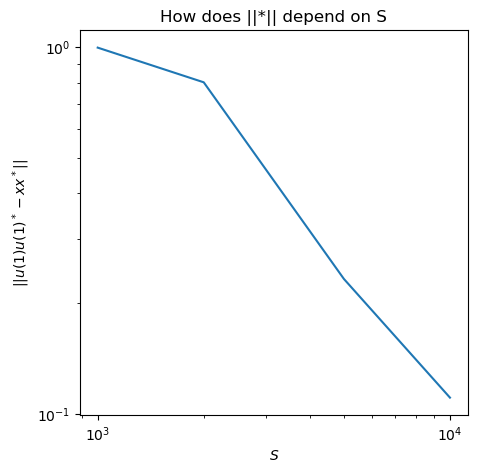

The slope estimation over the full interval of S is: 
-1.0467252262635731

In [174]:
using PyPlot
using Plots
figure(1,figsize=(5,5))
st=1
#plot(s_array,vec(errors_array),"bo")
loglog(s_array, reverse(errors_array))
xlabel(L"S")
ylabel(L"|| u(1)u(1)^* - xx^* ||")
title("How does ||*|| depend on S")

println("The slope estimation over the full interval of S is: ")
print(-(log(10000)-log(1000))/(log(errors_array[end])-log(errors_array[1])))